<h1><center><font size="6">Robots need help!</font></center></h1>

<img src="https://upload.wikimedia.org/wikipedia/commons/d/df/RobotsMODO.jpg" width="400"></img>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
 - <a href='#31'>Check the data</a>   
 - <a href='#32'>Distribution of target feature - surface</a>   
 - <a href='#33'>Distribution of group_id</a>    
 - <a href='#34'>Density plots of features</a>   
 - <a href='#35'>Target feature - surface and group_id distribution</a>   
 - <a href='#36'>Features correlation</a>   
- <a href='#4'>Feature engineering</a>
- <a href='#5'>Model</a>
- <a href='#6'>Submission</a>  
- <a href='#7'>References</a>

# <a id='1'>Introduction</a>  

## Competition
In this competition, we willl help robots recognize the floor surface they’re standing on. The floor could be of various types, like carpet, tiles, concrete.

## Data
The data provided by the organizers  is collected IMU sensor data while driving a small mobile robot over different floor surfaces on the university premises.  

## Kernel
In this Kernel we perform EDA on the data, explore with feature engineering and build a predictive model.

# <a id='2'>Prepare for data analysis</a>  


## Load packages


In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from lightgbm import LGBMClassifier
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

## Load data   

Let's check what data files are available.

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="../input/careercon/"
else:
    PATH="../input/"
os.listdir(PATH)

['y_train.csv', 'sample_submission.csv', 'X_train.csv', 'X_test.csv']

Let's load the data.

In [3]:
%%time
X_train = pd.read_csv(os.path.join(PATH, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(PATH, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(PATH, 'y_train.csv'))

CPU times: user 2.08 s, sys: 892 ms, total: 2.97 s
Wall time: 2.97 s


In [4]:
print("Train X: {}\nTrain y: {}\nTest X: {}".format(X_train.shape, y_train.shape, X_test.shape))

Train X: (487680, 13)
Train y: (3810, 3)
Test X: (488448, 13)


We can observe that train data and labels have different number of rows.

# <a id='3'>Data exploration</a>  

## <a id='31'>Check the data</a>  

Let's check the train and test set.

In [5]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [6]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [7]:
X_test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


X_train and X_test datasets have the following entries:  

* series and measurements identifiers: **row_id**, **series_id**, **measurement_number**: these identify uniquely a series and measurement; there are 3809 series, each with max 127 measurements;  
* measurement orientations: **orientation_X**, **orientation_Y**, **orientation_Z**, **orientation_W**;   
* angular velocities: **angular_velocity_X**, **angular_velocity_Y**, **angular_velocity_Z**;
* linear accelerations: **linear_acceleration_X**, **linear_acceleration_Y**, **linear_acceleration_Z**.

y_train has the following columns:  

* **series_id** - this corresponds to the series in train data;  
* **group_id**;  
* **surface** - this is the surface type that need to be predicted.



In [8]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [9]:
missing_data(X_train)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [10]:
missing_data(X_test)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


There are no missing values in train and test data.

In [11]:
missing_data(y_train)

,series_id,group_id,surface
Total,0,0,0
Percent,0,0,0
Types,int64,int64,object


Also, train labels has no missing data.

In [12]:
X_train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [13]:
X_test.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098435,-0.037396,-0.029865,-0.089842,-0.486233,2.052100,-10.125000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000


In [14]:
y_train.describe()

,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


There is the same number of series in X_train and y_train, numbered from 0 to 3809 (total 3810). Each series have 128 measurements.   
Each series in train dataset is part of a group (numbered from 0 to 72).  
The number of rows in X_train and X_test differs with 6 x 128, 128 being the number of measurements for each group.  

## <a id='32'>Distribution of target feature - surface</a>  


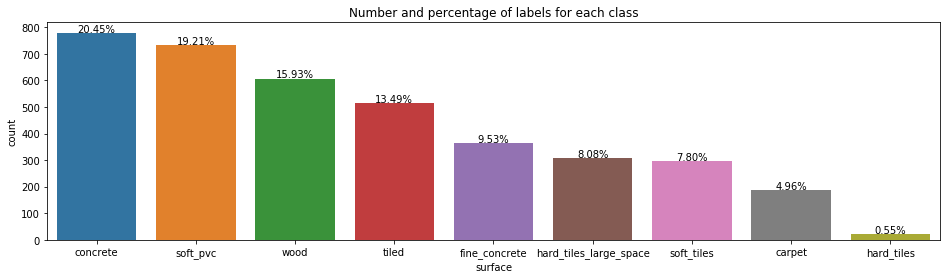

In [15]:
f, ax = plt.subplots(1,1, figsize=(16,4))
total = float(len(y_train))
g = sns.countplot(y_train['surface'], order = y_train['surface'].value_counts().index)
g.set_title("Number and percentage of labels for each class")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()    

## <a id='33'>Distribution of group_id</a>  

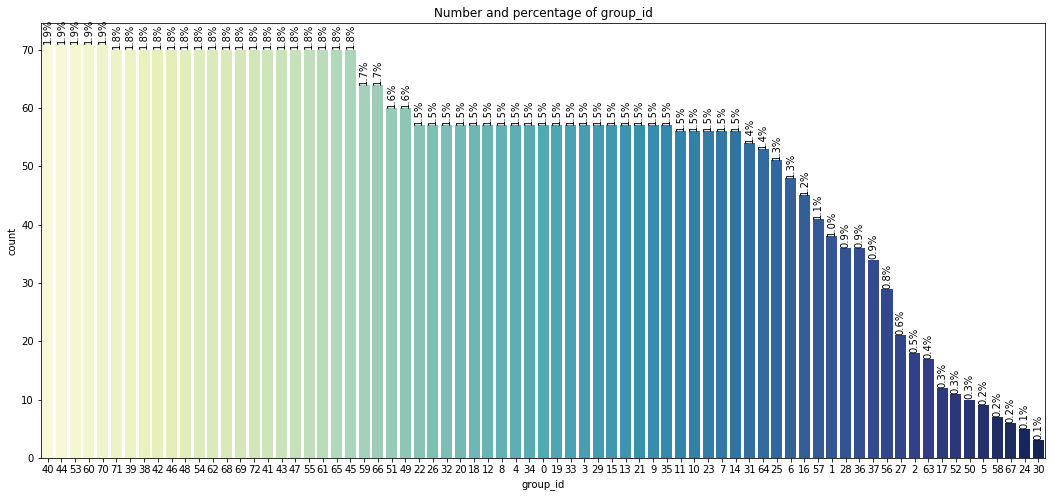

In [16]:
f, ax = plt.subplots(1,1, figsize=(18,8))
total = float(len(y_train))
g = sns.countplot(y_train['group_id'], order = y_train['group_id'].value_counts().index, palette='YlGnBu')
g.set_title("Number and percentage of group_id")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(100*height/total),
            ha="center", rotation='90') 
plt.show()    

## <a id='34'>Density plots of features</a>  

Let's show now the density plot of variables in train and test dataset. 

We represent with different colors the distribution for values with different values of **surface**.

In [17]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(16,8))

    for feature in features:
        i += 1
        plt.subplot(2,5,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

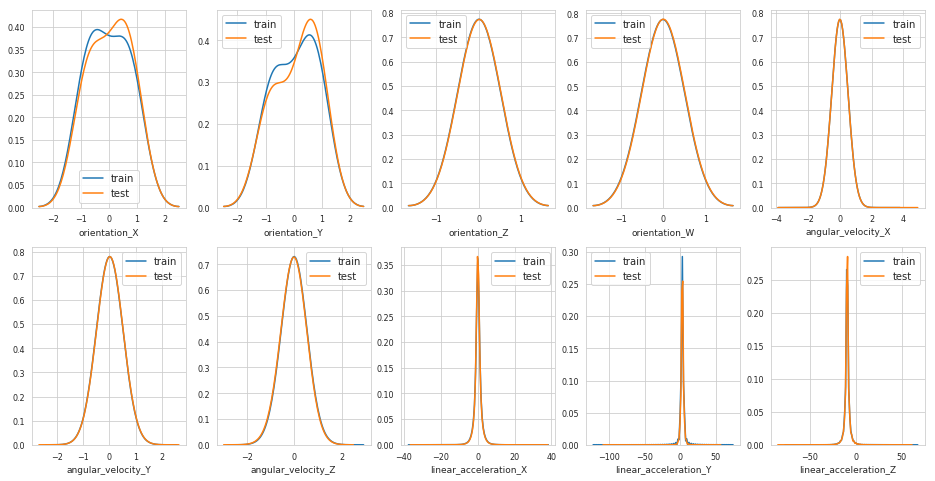

In [18]:
features = X_train.columns.values[3:]
plot_feature_distribution(X_train, X_test, 'train', 'test', features)

In [19]:
def plot_feature_class_distribution(classes,tt, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(5,2,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(5,2,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

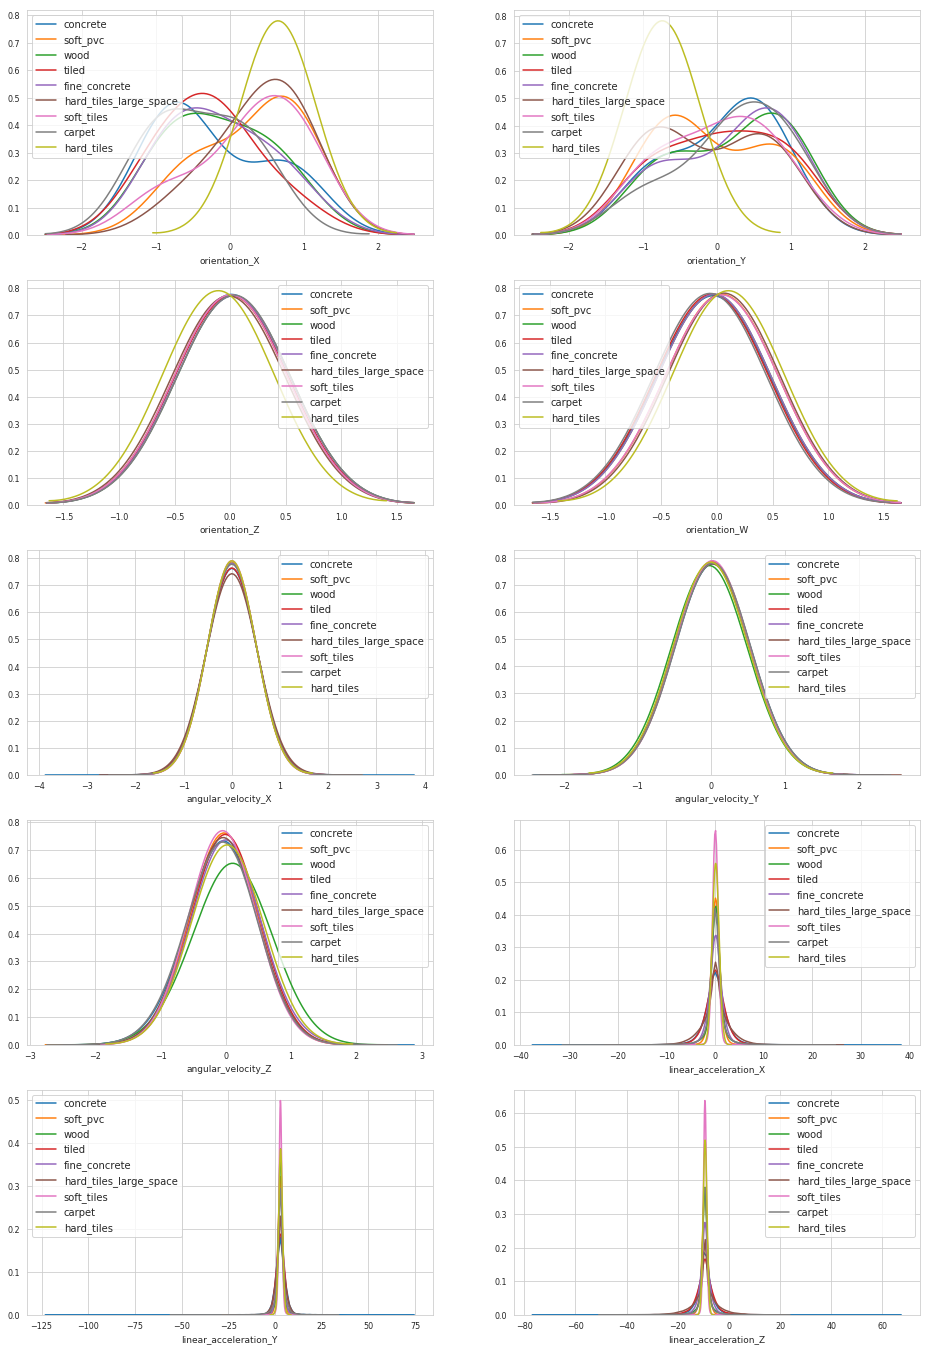

In [20]:
classes = (y_train['surface'].value_counts()).index
tt = X_train.merge(y_train, on='series_id', how='inner')
plot_feature_class_distribution(classes, tt, features)

## <a id='35'>Target feature - surface and group_id distribution</a>  

Let's show now the distribution of target feature - surface and group_id.

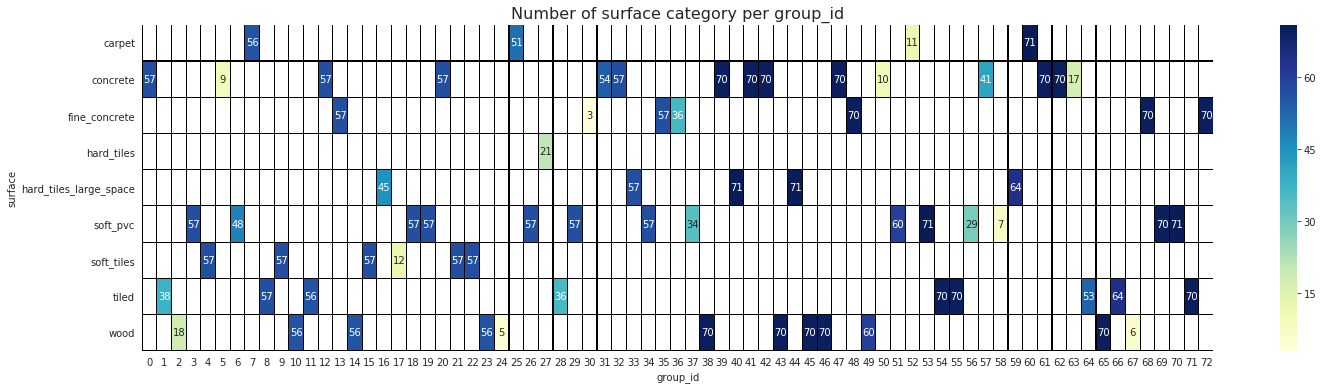

In [21]:
fig, ax = plt.subplots(1,1,figsize=(24,6))
tmp = pd.DataFrame(y_train.groupby(['group_id', 'surface'])['series_id'].count().reset_index())
m = tmp.pivot(index='surface', columns='group_id', values='series_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of surface category per group_id', size=16)
plt.show()

# <a id='36'>Features correlation</a>  

Let's check the features correlation for train set.

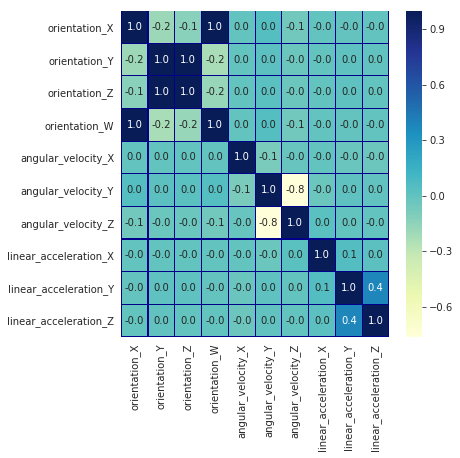

In [22]:
f,ax = plt.subplots(figsize=(6,6))
m = X_train.iloc[:,3:].corr()
sns.heatmap(m, annot=True, linecolor='darkblue', linewidths=.1, cmap="YlGnBu", fmt= '.1f',ax=ax)

Very strong correlation (1.0) is between **orientation_X** and **orientation_W** and between **orientation_Z** and **orientation_Y**.   
There is a strong inverse correlation (-0.8) between **angular_velocity_Z** and **angular_velocity_Y**.    
Also, there is a medium positive correlation (0.4) between **linear_acceleration_Y** and **linear_acceleration_Z**.  

Let's also check the features correlation for test set.


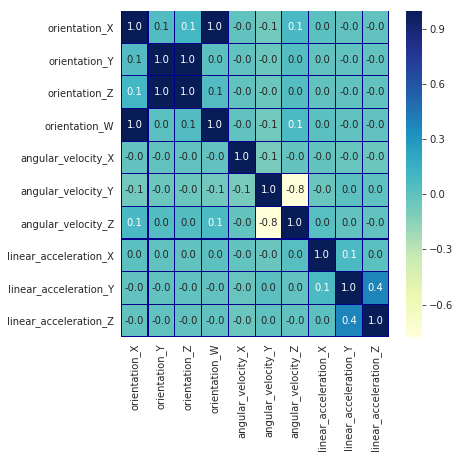

In [23]:
f,ax = plt.subplots(figsize=(6,6))
m = X_test.iloc[:,3:].corr()
sns.heatmap(m, annot=True, linecolor='darkblue', linewidths=.1, cmap="YlGnBu", fmt= '.1f',ax=ax)

Very strong correlation (1.0) is between **orientation_X** and **orientation_W** and between **orientation_Z** and **orientation_Y**.   
There is a strong inverse correlation (-0.8) between **angular_velocity_Z** and **angular_velocity_Y**.    
Also, there is a medium positive correlation (0.4) between **linear_acceleration_Y** and **linear_acceleration_Z**.  

# <a id='4'>Feature engineering</a>  


This section is heavily borrowing from: https://www.kaggle.com/vanshjatana/help-humanity-by-helping-robots Kernel. 
The quaternion_to_euler transformation procedure is also credited in the original Kernel, and I kept this reference as well.
I also corrected few issues and added some more engineered features. Thanks for @timmmmmms for pointing them out.

In [24]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [25]:
def perform_feature_engineering(df):
    df_out = pd.DataFrame()
    df['total_angular_velocity'] = np.sqrt(np.square(df['angular_velocity_X']) + np.square(df['angular_velocity_Y']) + np.square(df['angular_velocity_Z']))
    df['total_linear_acceleration'] = np.sqrt(np.square(df['linear_acceleration_X']) + np.square(df['linear_acceleration_Y']) + np.square(df['linear_acceleration_Z']))
    df['total_xyz'] = np.sqrt(np.square(df['orientation_X']) + np.square(df['orientation_Y']) +
                              np.square(df['orientation_Z']))
    df['acc_vs_vel'] = df['total_linear_acceleration'] / df['total_angular_velocity']
    
    x, y, z, w = df['orientation_X'].tolist(), df['orientation_Y'].tolist(), df['orientation_Z'].tolist(), df['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    df['euler_x'] = nx
    df['euler_y'] = ny
    df['euler_z'] = nz
    
    df['total_angle'] = np.sqrt(np.square(df['euler_x']) + np.square(df['euler_y']) + np.square(df['euler_z']))
    df['angle_vs_acc'] = df['total_angle'] / df['total_linear_acceleration']
    df['angle_vs_vel'] = df['total_angle'] / df['total_angular_velocity']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

    def mean_abs_change(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in df.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        df_out[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        df_out[col + '_min'] = df.groupby(['series_id'])[col].min()
        df_out[col + '_max'] = df.groupby(['series_id'])[col].max()
        df_out[col + '_std'] = df.groupby(['series_id'])[col].std()
        df_out[col + '_mad'] = df.groupby(['series_id'])[col].mad()
        df_out[col + '_med'] = df.groupby(['series_id'])[col].median()
        df_out[col + '_skew'] = df.groupby(['series_id'])[col].skew()
        df_out[col + '_range'] = df_out[col + '_max'] - df_out[col + '_min']
        df_out[col + '_max_to_min'] = df_out[col + '_max'] / df_out[col + '_min']
        df_out[col + '_mean_abs_change'] = df.groupby('series_id')[col].apply(mean_abs_change)
        df_out[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df_out[col + '_abs_max'] = df.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        df_out[col + '_abs_min'] = df.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))
        df_out[col + '_abs_mean'] = df.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(x)))
        df_out[col + '_abs_std'] = df.groupby('series_id')[col].apply(lambda x: np.std(np.abs(x)))
        df_out[col + '_abs_avg'] = (df_out[col + '_abs_min'] + df_out[col + '_abs_max'])/2
        df_out[col + '_abs_range'] = df_out[col + '_abs_max'] - df_out[col + '_abs_min']

    return df_out

In [26]:
%%time
X_train = perform_feature_engineering(X_train)

CPU times: user 2min 5s, sys: 1.07 s, total: 2min 6s
Wall time: 2min 5s


In [27]:
%%time
X_test = perform_feature_engineering(X_test)

CPU times: user 2min 4s, sys: 432 ms, total: 2min 4s
Wall time: 2min 4s


After feature engineering, the new shapes are:

In [28]:
print("Train X: {}\nTrain y: {}\nTest X: {}".format(X_train.shape, y_train.shape, X_test.shape))

Train X: (3810, 340)
Train y: (3810, 3)
Test X: (3816, 340)


In [29]:
X_train.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_mad,orientation_X_med,orientation_X_skew,orientation_X_range,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_mean,orientation_X_abs_std,orientation_X_abs_avg,orientation_X_abs_range,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_mad,orientation_Y_med,orientation_Y_skew,orientation_Y_range,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_mean,orientation_Y_abs_std,orientation_Y_abs_avg,orientation_Y_abs_range,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_mad,orientation_Z_med,...,total_angle_abs_max,total_angle_abs_min,total_angle_abs_mean,total_angle_abs_std,total_angle_abs_avg,total_angle_abs_range,angle_vs_acc_mean,angle_vs_acc_min,angle_vs_acc_max,angle_vs_acc_std,angle_vs_acc_mad,angle_vs_acc_med,angle_vs_acc_skew,angle_vs_acc_range,angle_vs_acc_max_to_min,angle_vs_acc_mean_abs_change,angle_vs_acc_mean_change_of_abs_change,angle_vs_acc_abs_max,angle_vs_acc_abs_min,angle_vs_acc_abs_mean,angle_vs_acc_abs_std,angle_vs_acc_abs_avg,angle_vs_acc_abs_range,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel_mad,angle_vs_vel_med,angle_vs_vel_skew,angle_vs_vel_range,angle_vs_vel_max_to_min,angle_vs_vel_mean_abs_change,angle_vs_vel_mean_change_of_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min,angle_vs_vel_abs_mean,angle_vs_vel_abs_std,angle_vs_vel_abs_avg,angle_vs_vel_abs_range
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.000311,-0.758530,-0.659082,0.00131,0.998275,0.000015,2.380952e-07,0.75953,0.75822,0.758666,0.000361,0.758875,0.00131,-0.634008,-0.63456,-0.63306,0.000471,0.000421,-0.634270,0.603197,0.00150,0.997636,0.000018,0.000000e+00,0.63456,0.63306,0.634008,0.000469,0.633810,0.00150,-0.105474,-0.106140,-0.104610,0.000432,0.000379,-0.105500,...,3.168565,3.164289,3.166227,0.001178,3.166427,0.004276,0.321935,0.251897,0.445076,0.034786,0.025727,0.314206,1.200153,0.193179,1.766897,0.023178,0.000123,0.445076,0.251897,0.321935,0.034650,0.348486,0.193179,71.253309,19.504720,298.761364,44.060971,29.995696,60.141224,2.572775,279.256644,15.317388,37.481365,0.280575,298.761364,19.504720,71.253309,43.888520,159.133042,279.256644
1,-0.958606,-0.95896,-0.95837,0.000151,0.000126,-0.958595,-0.397289,0.00059,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.958606,0.000151,0.958665,0.00059,0.241867,0.24074,0.24270,0.000499,0.000401,0.241890,-0.422565,0.00196,1.008142,0.000070,1.587302e-07,0.24270,0.24074,0.241867,0.000497,0.241720,0.00196,0.031650,0.030504,0.032341,0.000508,0.000422,0.031688,...,2.884601,2.880123,2.882573,0.001102,2.882362,0.004478,0.295598,0.169758,0.491481,0.056245,0.042173,0.286182,0.946349,0.321723,2.895188,0.041363,-0.001057,0.491481,0.169758,0.295598,0.056025,0.330620,0.321723,33.584444,10.012514,142.881670,21.735220,14.277087,28.475504,2.584053,132.869156,14.270310,14.932243,0.040438,142.881670,10.012514,33.584444,21.650150,76.447092,132.869156
2,-0.512057,-0.51434,-0.50944,0.001377,0.001144,-0.512035,0.151971,0.00490,0.990473,0.000041,0.000000e+00,0.51434,0.50944,0.512057,0.001372,0.511890,0.00490,-0.846171,-0.84779,-0.84490,0.000785,0.000673,-0.846210,-0.161786,0.00289,0.996591,0.000024,-7.142857e-07,0.84779,0.84490,0.846171,0.000782,0.846345,0.00289,-0.129371,-0.130300,-0.128520,0.000541,0.000468,-0.129405,...,3.514136,3.507709,3.510029,0.001598,3.510922,0.006427,0.352936,0.276047,0.517216,0.034568,0.026624,0.348038,0.906851,0.241169,1.873654,0.025316,-0.000331,0.517216,0.276047,0.352936,0.034433,0.396632,0.241169,66.487159,20.553513,355.472539,47.187945,31.346030,52.159415,2.816408,334.919026,17.294977,29.160415,-0.11

In [30]:
X_test.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_mad,orientation_X_med,orientation_X_skew,orientation_X_range,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_mean,orientation_X_abs_std,orientation_X_abs_avg,orientation_X_abs_range,orientation_Y_mean,orientation_Y_min,orientation_Y_max,orientation_Y_std,orientation_Y_mad,orientation_Y_med,orientation_Y_skew,orientation_Y_range,orientation_Y_max_to_min,orientation_Y_mean_abs_change,orientation_Y_mean_change_of_abs_change,orientation_Y_abs_max,orientation_Y_abs_min,orientation_Y_abs_mean,orientation_Y_abs_std,orientation_Y_abs_avg,orientation_Y_abs_range,orientation_Z_mean,orientation_Z_min,orientation_Z_max,orientation_Z_std,orientation_Z_mad,orientation_Z_med,...,total_angle_abs_max,total_angle_abs_min,total_angle_abs_mean,total_angle_abs_std,total_angle_abs_avg,total_angle_abs_range,angle_vs_acc_mean,angle_vs_acc_min,angle_vs_acc_max,angle_vs_acc_std,angle_vs_acc_mad,angle_vs_acc_med,angle_vs_acc_skew,angle_vs_acc_range,angle_vs_acc_max_to_min,angle_vs_acc_mean_abs_change,angle_vs_acc_mean_change_of_abs_change,angle_vs_acc_abs_max,angle_vs_acc_abs_min,angle_vs_acc_abs_mean,angle_vs_acc_abs_std,angle_vs_acc_abs_avg,angle_vs_acc_abs_range,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel_mad,angle_vs_vel_med,angle_vs_vel_skew,angle_vs_vel_range,angle_vs_vel_max_to_min,angle_vs_vel_mean_abs_change,angle_vs_vel_mean_change_of_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min,angle_vs_vel_abs_mean,angle_vs_vel_abs_std,angle_vs_vel_abs_avg,angle_vs_vel_abs_range
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.025810,-0.026418,-0.025156,0.000284,0.000238,-0.025748,-0.389316,0.001262,0.952230,0.000055,-1.269841e-07,0.026418,0.025156,0.025810,0.000283,0.025787,0.001262,-0.988644,-0.98873,-0.98854,0.000039,0.000033,-0.988645,0.203751,0.00019,0.999808,0.000015,8.811294e-19,0.98873,0.98854,0.988644,0.000039,0.988635,0.00019,-0.148006,-0.148720,-0.147480,0.000253,0.000214,-0.148010,...,4.202686,4.199968,4.201174,0.000606,4.201327,0.002717,0.436079,0.252807,0.685114,0.084013,0.068964,0.422753,0.483141,0.432307,2.710027,0.067764,0.000181,0.685114,0.252807,0.436079,0.083684,0.468961,0.432307,53.476821,18.078877,389.017326,42.672600,20.896933,44.387368,5.634979,370.938449,21.517782,28.257408,-0.923973,389.017326,18.078877,53.476821,42.505583,203.548101,370.938449
1,-0.932288,-0.933720,-0.931480,0.000564,0.000481,-0.932115,-0.763507,0.002240,0.997601,0.000021,-3.968254e-07,0.933720,0.931480,0.932288,0.000562,0.932600,0.002240,0.330271,0.32661,0.33227,0.001654,0.001389,0.330815,-0.691798,0.00566,1.017330,0.000050,7.936508e-08,0.33227,0.32661,0.330271,0.001647,0.329440,0.00566,0.043416,0.042283,0.044053,0.000326,0.000230,0.043395,...,2.928767,2.923066,2.925688,0.001630,2.925916,0.005700,0.296638,0.217737,0.727116,0.050142,0.025518,0.293376,5.450641,0.509379,3.339422,0.021401,0.001421,0.727116,0.217737,0.296638,0.049946,0.472427,0.509379,45.941738,10.080219,281.964422,37.264691,19.956474,36.942279,4.140890,271.884204,27.972054,18.030019,0.164963,281.964422,10.080219,45.941738,37.118840,146.022321,271.884204
2,-0.230186,-0.231410,-0.227130,0.001054,0.000876,-0.230600,0.935914,0.004280,0.981505,0.000093,-1.746032e-06,0.231410,0.227130,0.230186,0.001050,0.229270,0.004280,0.961448,0.96109,0.96217,0.000260,0.000213,0.961360,0.882054,0.00108,1.001124,0.000030,-7.142857e-07,0.96217,0.96109,0.961448,0.000259,0.961630,0.00108,0.144340,0.143560,0.145110,0.000335,0.000272,0.144395,...,3.901766,3.894967,3.897528,0.001623,3.898366,0.006799,0.394123,0.233050,0.708634,0.095239,0.074470,0.380777,0.909267,0.475585,3.040699,0.070720,-0.000423,0.708634,0.233050,0.394123,0.094866,0.470842,0.475585,35.832008,11.928777,143.558755,22.780996,15.502113,28.373288,2.389147,131.629978,12.034658,15.

## Features correlation


Let's look now to the new features correlation for train set.

In [31]:
%%time
correlations = X_train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

CPU times: user 960 ms, sys: 0 ns, total: 960 ms
Wall time: 963 ms


Let's see the least correlated features.

In [32]:
correlations.head(10)

,level_0,level_1,0
0,angular_velocity_Z_abs_avg,orientation_Y_mean_change_of_abs_change,3.946501e-07
1,orientation_Y_mean_change_of_abs_change,angular_velocity_Z_abs_avg,3.946501e-07
2,acc_vs_vel_abs_max,euler_y_mean_change_of_abs_change,1.826967e-06
3,euler_y_mean_change_of_abs_change,acc_vs_vel_max,1.826967e-06
4,euler_y_mean_change_of_abs_change,acc_vs_vel_abs_max,1.826967e-06
5,acc_vs_vel_max,euler_y_mean_change_of_abs_change,1.826967e-06
6,euler_y_min,angular_velocity_Y_mean_change_of_abs_change,2.067884e-06
7,angular_velocity_Y_mean_change_of_abs_change,euler_y_min,2.067884e-06
8,orientation_Y_std,angular_velocity_Z_skew,2.514179e-06
9,angular_velocity_Z_skew,orientation_Y_std,2.514179e-06


And let's see now the most correlated features. We show only the first 10, then we print the total number of them.

In [33]:
correlations.tail(10)

,level_0,level_1,0
115584,acc_vs_vel_abs_mean,acc_vs_vel_mean,1.0
115589,acc_vs_vel_abs_range,acc_vs_vel_range,1.0
115592,acc_vs_vel_std,acc_vs_vel_abs_std,1.0
115593,acc_vs_vel_abs_std,acc_vs_vel_std,1.0
115594,total_angular_velocity_std,total_angular_velocity_abs_std,1.0
115595,total_angular_velocity_abs_std,total_angular_velocity_std,1.0
115596,total_linear_acceleration_abs_std,total_linear_acceleration_std,1.0
115597,total_linear_acceleration_std,total_linear_acceleration_abs_std,1.0
115598,total_angle_std,total_angle_abs_std,1.0
115599,total_angle_abs_std,total_angle_std,1.0


In [34]:
n_top_corr = correlations[correlations[0]==1.0].shape[0]
print("There are {} different features pairs with correlation factor 1.0.".format(n_top_corr))

There are 64 different features pairs with correlation factor 1.0.


We eliminate the features that have a correlation factor 1.0 with other features.   


In [35]:
drop_features = list(correlations.head(n_top_corr)['level_0'].unique())
X_train = X_train.drop(drop_features,axis=1)
X_test = X_test.drop(drop_features,axis=1)


Let's show again the shape of train and test.

In [36]:
print("Train X: {}\nTrain y: {}\nTest X: {}".format(X_train.shape, y_train.shape, X_test.shape))

Train X: (3810, 288)
Train y: (3810, 3)
Test X: (3816, 288)


# <a id='5'>Model</a>  

We use LabelEncoder for the target feature.

In [37]:
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])

We replace with 0 NAs and $\infty$.

In [38]:
X_train.fillna(0, inplace = True)
X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_test.fillna(0, inplace = True)
X_test.replace(-np.inf, 0, inplace = True)
X_test.replace(np.inf, 0, inplace = True)

## Prepare for cross-validation

In [39]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)

## Random Forest classifier

We use first a Random Forest Classifier model.

In [40]:
sub_preds_rf = np.zeros((X_test.shape[0], 9))
oof_preds_rf = np.zeros((X_train.shape[0]))
score = 0
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train['surface'])):
    clf =  RandomForestClassifier(n_estimators = 500, n_jobs = -1)
    clf.fit(X_train.iloc[trn_idx], y_train['surface'][trn_idx])
    oof_preds_rf[val_idx] = clf.predict(X_train.iloc[val_idx])
    sub_preds_rf += clf.predict_proba(X_test) / folds.n_splits
    score += clf.score(X_train.iloc[val_idx], y_train['surface'][val_idx])
    print('Fold: {} score: {}'.format(fold_,clf.score(X_train.iloc[val_idx], y_train['surface'][val_idx])))
print('Avg Accuracy', score / folds.n_splits)

Fold: 0 score: 0.8981723237597912
Fold: 1 score: 0.9006535947712418
Fold: 2 score: 0.9002624671916011
Fold: 3 score: 0.8894736842105263
Fold: 4 score: 0.9101717305151915
Avg Accuracy 0.8997467600896704


Let's check the confusion matrix.

We will use a simplifed version of the plot function defined here: # https://www.kaggle.com/artgor/where-do-the-robots-drive

In [41]:
def plot_confusion_matrix(actual, predicted, classes, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(actual, predicted)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title, size=12)
    plt.colorbar(fraction=0.05, pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
        horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

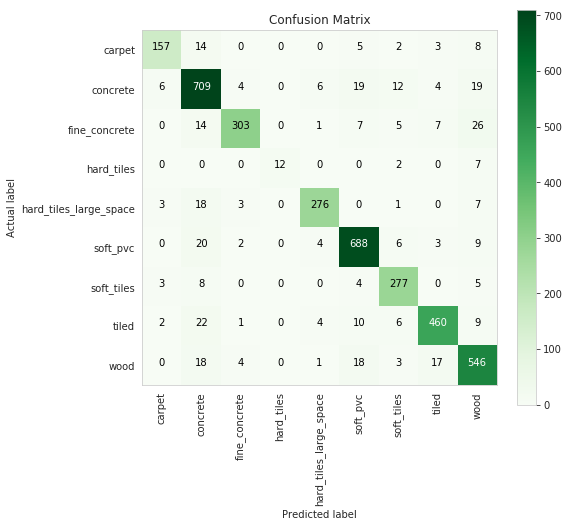

In [42]:
plot_confusion_matrix(y_train['surface'], oof_preds_rf, le.classes_, title='Confusion Matrix')


## LightGBM Classifier

We also use a LightGBM Classifier model.

In [43]:
USE_LGB = False
if(USE_LGB):
    sub_preds_lgb = np.zeros((X_test.shape[0], 9))
    oof_preds_lgb = np.zeros((X_train.shape[0]))
    score = 0
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train['surface'])):
        train_x, train_y = X_train.iloc[trn_idx], y_train['surface'][trn_idx]
        valid_x, valid_y = X_train.iloc[val_idx], y_train['surface'][val_idx]
        clf =  LGBMClassifier(
                      nthread=-1,
                      n_estimators=2000,
                      learning_rate=0.01,
                      boosting_type='gbdt',
                      is_unbalance=True,
                      objective='multiclass',
                      numclass=9,
                      silent=-1,
                      verbose=-1,
                      feval=None)
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                     verbose= 1000, early_stopping_rounds= 200)

        oof_preds_lgb[val_idx] = clf.predict(valid_x)
        sub_preds_lgb += clf.predict_proba(X_test) / folds.n_splits
        score += clf.score(valid_x, valid_y)
        print('Fold: {} score: {}'.format(fold_,clf.score(valid_x, valid_y)))
    print('Avg Accuracy', score / folds.n_splits)

# <a id='6'>Submission</a>  

We submit the solution for both the RF and LGB.

In [44]:
submission = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))
submission['surface'] = le.inverse_transform(sub_preds_rf.argmax(axis=1))
submission.to_csv('submission_rf.csv', index=False)
submission.head(10)

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,concrete
8,8,wood
9,9,wood


In [45]:
USE_LGB = False
if(USE_LGB):
    submission['surface'] = le.inverse_transform(sub_preds_lgb.argmax(axis=1))
    submission.to_csv('submission_lgb.csv', index=False)
    submission.head(10)

# <a id='7'>References</a>    

[1] https://www.kaggle.com/vanshjatana/help-humanity-by-helping-robots-4e306b  
[2] https://www.kaggle.com/artgor/where-do-the-robots-drive  
